In [37]:
import os

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

import shutil
shutil.copy("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

In [38]:
import kaggle
kaggle.api.authenticate()

DATA_ROOT_DIR_PATH = os.path.join('data', 'fer2013')

# Check if dataset already exists before downloading
if os.path.exists('data') and os.path.exists(DATA_ROOT_DIR_PATH):
    print("Dataset already exists, skipping download")
else:
    kaggle.api.dataset_download_files('msambare/fer2013', path=DATA_ROOT_DIR_PATH, unzip=True)
    print("Dataset downloaded")

Dataset already exists, skipping download


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import glob

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [41]:
TRAIN_IMAGE_DIR_PATH = os.path.join(DATA_ROOT_DIR_PATH, "train")
TEST_IMAGE_DIR_PATH = os.path.join(DATA_ROOT_DIR_PATH, "test")
BATCH_SIZE = 128
IMAGE_SIZE = 48
LR = 0.001
EPOCHS = 50

In [42]:
dirs = os.listdir(TRAIN_IMAGE_DIR_PATH)
labels_map = {label: index for index, label in enumerate(dirs)}
labels_map

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [43]:
train_data: list[tuple[str, int]] = []
test_data: list[tuple[str, int]] = []

for label, index in labels_map.items():
    train_image_paths = [(image_path, index) for image_path in glob.glob(f"{TRAIN_IMAGE_DIR_PATH}/{label}/*.jpg")]
    test_image_paths = [(image_path, index) for image_path in glob.glob(f"{TEST_IMAGE_DIR_PATH}/{label}/*.jpg")]
    
    train_data.extend(train_image_paths)
    test_data.extend(test_image_paths)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=420, stratify=[label for _, label in train_data])

In [44]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5]),
])

In [45]:
class EmotionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [46]:
train_dataset = EmotionDataset(train_data, train_transform)
val_dataset = EmotionDataset(val_data, test_transform)
test_dataset = EmotionDataset(test_data, test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [47]:
class EmotionsDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 7),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [48]:
model = EmotionsDetector().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [49]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss / total)
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [50]:
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, all_preds, all_labels

In [51]:
def plot_metrics(train_losses, val_losses, train_acc, val_acc):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label = 'Train Loss')
    plt.plot(epochs, val_losses, label = 'Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label = 'Train Acc')
    plt.plot(epochs, val_acc, label = 'Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()

In [52]:
train_losses, val_losses, train_acc, val_acc = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
)

Epoch 1/50 | Train Loss: 1.6406, Acc: 0.3404 | Val Loss: 1.4134, Acc: 0.4566
Epoch 2/50 | Train Loss: 1.3601, Acc: 0.4798 | Val Loss: 1.2850, Acc: 0.4904
Epoch 3/50 | Train Loss: 1.2529, Acc: 0.5259 | Val Loss: 1.1683, Acc: 0.5509
Epoch 4/50 | Train Loss: 1.1824, Acc: 0.5521 | Val Loss: 1.2353, Acc: 0.5235
Epoch 5/50 | Train Loss: 1.1261, Acc: 0.5741 | Val Loss: 1.1150, Acc: 0.5752
Epoch 6/50 | Train Loss: 1.0919, Acc: 0.5895 | Val Loss: 1.1687, Acc: 0.5688
Epoch 7/50 | Train Loss: 1.0491, Acc: 0.6046 | Val Loss: 1.1038, Acc: 0.5775
Epoch 8/50 | Train Loss: 1.0138, Acc: 0.6201 | Val Loss: 1.1211, Acc: 0.5914
Epoch 9/50 | Train Loss: 0.9805, Acc: 0.6340 | Val Loss: 1.1799, Acc: 0.5615
Epoch 10/50 | Train Loss: 0.9534, Acc: 0.6441 | Val Loss: 1.0582, Acc: 0.5986
Epoch 11/50 | Train Loss: 0.9127, Acc: 0.6599 | Val Loss: 1.0818, Acc: 0.6041
Epoch 12/50 | Train Loss: 0.8929, Acc: 0.6679 | Val Loss: 1.0843, Acc: 0.6073
Epoch 13/50 | Train Loss: 0.8603, Acc: 0.6803 | Val Loss: 1.0443, Acc: 0.

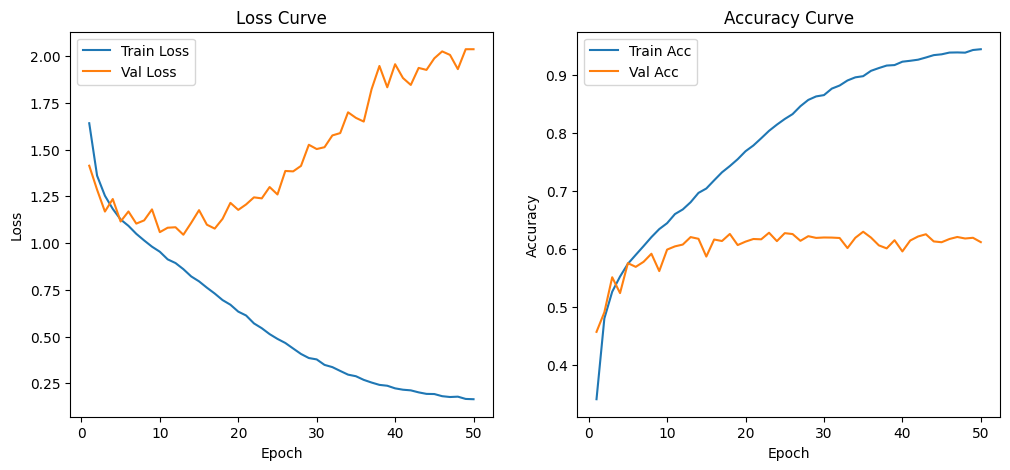

In [53]:
plot_metrics(train_losses, val_losses, train_acc, val_acc)

In [54]:
test_acc, test_preds, test_labels = test_model(model, test_loader, device)
print(f"Accuracy = {test_acc}")
print(f"Test Predictions = {test_preds}")
print(f"Test Labels = {test_labels}")

Test Accuracy: 0.6346
Accuracy = 0.634577876845918
Test Predictions = [0, 0, 5, 2, 2, 5, 2, 0, 4, 0, 2, 0, 0, 5, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 5, 5, 0, 2, 2, 2, 0, 2, 0, 5, 0, 0, 4, 0, 2, 0, 5, 0, 0, 2, 2, 0, 0, 0, 4, 0, 5, 0, 0, 2, 0, 0, 2, 5, 5, 5, 5, 2, 0, 2, 6, 0, 0, 5, 2, 2, 0, 0, 5, 5, 0, 0, 0, 0, 5, 0, 2, 0, 0, 4, 0, 5, 0, 0, 0, 0, 5, 5, 4, 0, 0, 0, 0, 0, 2, 5, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0, 3, 0, 2, 0, 4, 0, 5, 0, 0, 0, 2, 0, 0, 5, 5, 0, 2, 0, 0, 4, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 5, 2, 0, 0, 5, 0, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 4, 2, 4, 0, 0, 0, 0, 4, 2, 0, 0, 0, 2, 2, 0, 6, 0, 0, 0, 0, 5, 0, 2, 0, 0, 5, 2, 4, 5, 2, 0, 2, 6, 3, 0, 2, 2, 3, 5, 2, 5, 0, 0, 4, 3, 2, 0, 3, 0, 4, 2, 0, 5, 5, 0, 0, 5, 0, 0, 4, 0, 2, 0, 2, 2, 2, 2, 5, 0, 0, 0, 5, 5, 0, 2, 4, 0, 4, 3, 2, 3, 3, 4, 4, 4, 2, 0, 6, 5, 0, 0, 0, 0, 0, 2, 0, 4, 5, 2, 0, 2, 0, 0, 0, 0, 5, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 5, 4, 2, 0, 0, 0, 0, 3, 0, 5, 0, 0, 4, 5, 0, 0, 0, 5, 0, 0, 5, 0, 5, 0, 0, 0, 4, 2, 2, 0,